# `leaf.py`

## Setup

In [1]:
import math
import sys

import einops
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from scipy.fft import fft, fftshift
import torch

sys.path.append('../scripts/')

from utils import set_seaborn_whitegrid_ticks
from complexfunctional import real_to_cmplx, cmplx_to_real
from leaf import LEAF, gaussian_lowpass
from featureinfo import AVAILABLE_FEATURES_INFO

set_seaborn_whitegrid_ticks()

## Model structure

In [2]:
LEAF(
    features=('power', 'inst_freq', 'inst_freq_rot', 'grp_dly', 'grp_dly_rot', 'phase_phasor', 'phase_phasor_rot'),
)

LEAF(
  sample_rate=16000, features=('power', 'inst_freq', 'inst_freq_rot', 'grp_dly', 'grp_dly_rot', 'phase_phasor', 'phase_phasor_rot'), phase_feat_attn_power=False
  (tf_converter): GaborConv1d(n_bins=40, n_resolutions=1, filter_size=401, stride=1, padding=same, sort_filters=True)
  (downsampler): ModuleDict(
    (power): GaussianLowpass(n_bins=40, n_resolutions=1, filter_size=401, stride=160, padding=same, trainable=True)
    (inst_freq): GaussianLowpass(n_bins=40, n_resolutions=1, filter_size=401, stride=160, padding=same, trainable=True)
    (inst_freq_rot): GaussianLowpass(n_bins=40, n_resolutions=1, filter_size=401, stride=160, padding=same, trainable=True)
    (grp_dly): GaussianLowpass(n_bins=40, n_resolutions=1, filter_size=401, stride=160, padding=same, trainable=True)
    (grp_dly_rot): GaussianLowpass(n_bins=40, n_resolutions=1, filter_size=401, stride=160, padding=same, trainable=True)
    (phase_phasor): GaussianLowpass(n_bins=40, n_resolutions=1, filter_size=401, strid

## Initial state

### `GaborConv1d`: Wave to Time-Frequency Converter

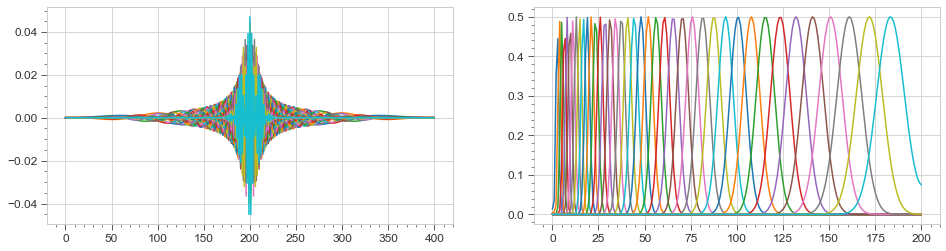

In [3]:
################################################################################
### Configuration
################################################################################
n_bins = 40  # default: 40
n_resolutions = 1  # default: 1; Experimental; Provide multiple time-frequency resolutions (σ) for a single center frequency (μ)
filter_size = 401  # default: 401
sample_rate = 16000  # default: 16000
tf_converter_min_freq = 60.0  # default: 60.0
tf_converter_max_freq = 7800.0  # default: 7800.0
tf_converter_norm = 'l1_rough'  # default: 'l1_rough'


################################################################################
### Processing
################################################################################
net = LEAF(
    n_bins=n_bins,
    n_resolutions=n_resolutions,
    filter_size=filter_size,
    sample_rate=sample_rate,
    tf_converter_norm=tf_converter_norm,
    tf_converter_min_freq=tf_converter_min_freq,
    tf_converter_max_freq=tf_converter_max_freq,
)
filters_r, filters_i = cmplx_to_real(net.tf_converter.generate_filters().detach().cpu(), dim=0)#.numpy()
filters_r = einops.rearrange(filters_r, '(c f) t -> c f t', c = n_resolutions)

fig, axes = plt.subplots(n_resolutions, 2, figsize=(16, n_resolutions*4))

if n_resolutions == 1:
    axes[0].plot(filters_r[0].T);
    axes[1].plot(np.abs(np.fft.fft(filters_r[0])).T[:filter_size//2+1]);
else:
    for i in range(n_resolutions):
        axes[i, 0].plot(filters_r[i].T);
        axes[i, 1].plot(np.abs(np.fft.fft(filters_r[i])).T[:filter_size//2+1]);

### `GaussianLowpass`: Downsampler

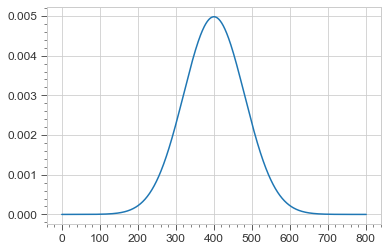

In [4]:
################################################################################
### Configuration
################################################################################
# Default: 0.4
# Any parameter value is internally constrained to be between
# 1/filter_size and 0.5 when filter generation.
downsampler_init = 0.4
downsampler_norm = 'l1_exact'


################################################################################
### Processing
################################################################################
net = LEAF(
    filter_size=401*2,
    downsampler_init=downsampler_init/2,
    downsampler_norm=downsampler_norm
)

fig, axes = plt.subplots(1, 1, figsize=(6, 4))
plt.plot(net.downsampler['power'].generate_filters()[0, 0].detach().numpy());

### `PCENLayer`: Comparison of LEAF and PCEN + melspectrogram

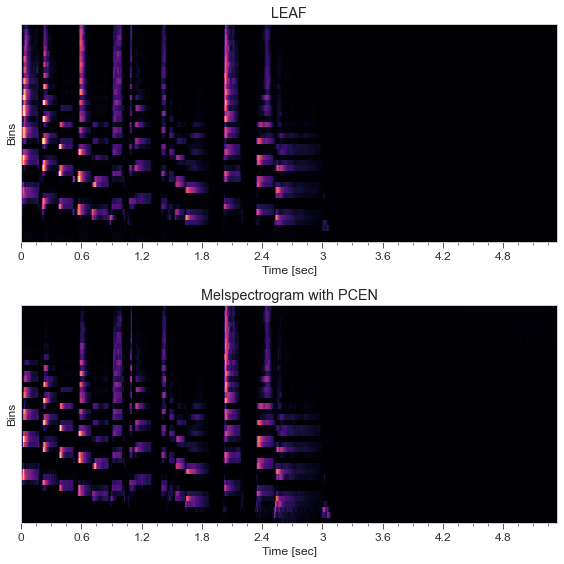

In [5]:
################################################################################
### Configuration
################################################################################
filter_size = 401
filter_stride = 160
n_bins = 40
sample_rate = 16000
tf_converter_min_freq = 60.0
tf_converter_max_freq = 7800.0
downsampler_init = 0.4

compressor_alpha = 0.96
compressor_delta = 2.0
compressor_root = 2.0
compressor_smooth_coef = 0.04


################################################################################
### Processing
################################################################################
net = LEAF(
    filter_size=filter_size,
    filter_stride=filter_stride,
    n_bins=n_bins,
    sample_rate=sample_rate,
    tf_converter_min_freq=tf_converter_min_freq,
    tf_converter_max_freq=tf_converter_max_freq,
    downsampler_init=downsampler_init,
    compressor_alpha=compressor_alpha,
    compressor_delta=compressor_delta,
    compressor_root=compressor_root,
    compressor_smooth_coef=compressor_smooth_coef,
)

wave, sample_rate = librosa.load(librosa.ex('trumpet'), sr=sample_rate)

output_mel = librosa.feature.melspectrogram(
    y=wave,
    n_fft=filter_size-1,
    hop_length=filter_stride,
    sr=sample_rate,
    n_mels=n_bins,
    htk=True,
    norm=2,
    fmin=tf_converter_min_freq,
    fmax=tf_converter_max_freq
)
output_mel = librosa.pcen(
    output_mel, sr=sample_rate,
    hop_length=filter_stride,
    gain=compressor_alpha,
    bias=compressor_delta,
    power=1/compressor_root,
    b=compressor_smooth_coef
)


output_net_torch = net(torch.from_numpy(wave.reshape(1, 1, -1)))  # shape=(1, 1, n_bins, time)
output_net = output_net_torch.squeeze(0).squeeze(0).detach().numpy()

fig, axes = plt.subplots(2, 1, figsize=(8, 8))

kwargs = dict(hop_length=filter_stride, sr=sample_rate, x_axis='s', cmap='magma')
librosa.display.specshow(output_net, ax=axes[0], **kwargs)
librosa.display.specshow(output_mel, ax=axes[1], **kwargs)

axes[0].set(title='LEAF', xlabel='Time [sec]', ylabel='Bins')
axes[1].set(title='Melspectrogram with PCEN', xlabel='Time [sec]', ylabel='Bins')

fig.tight_layout()

## Display all features

For complex features, only the real part of the feature is displayed.

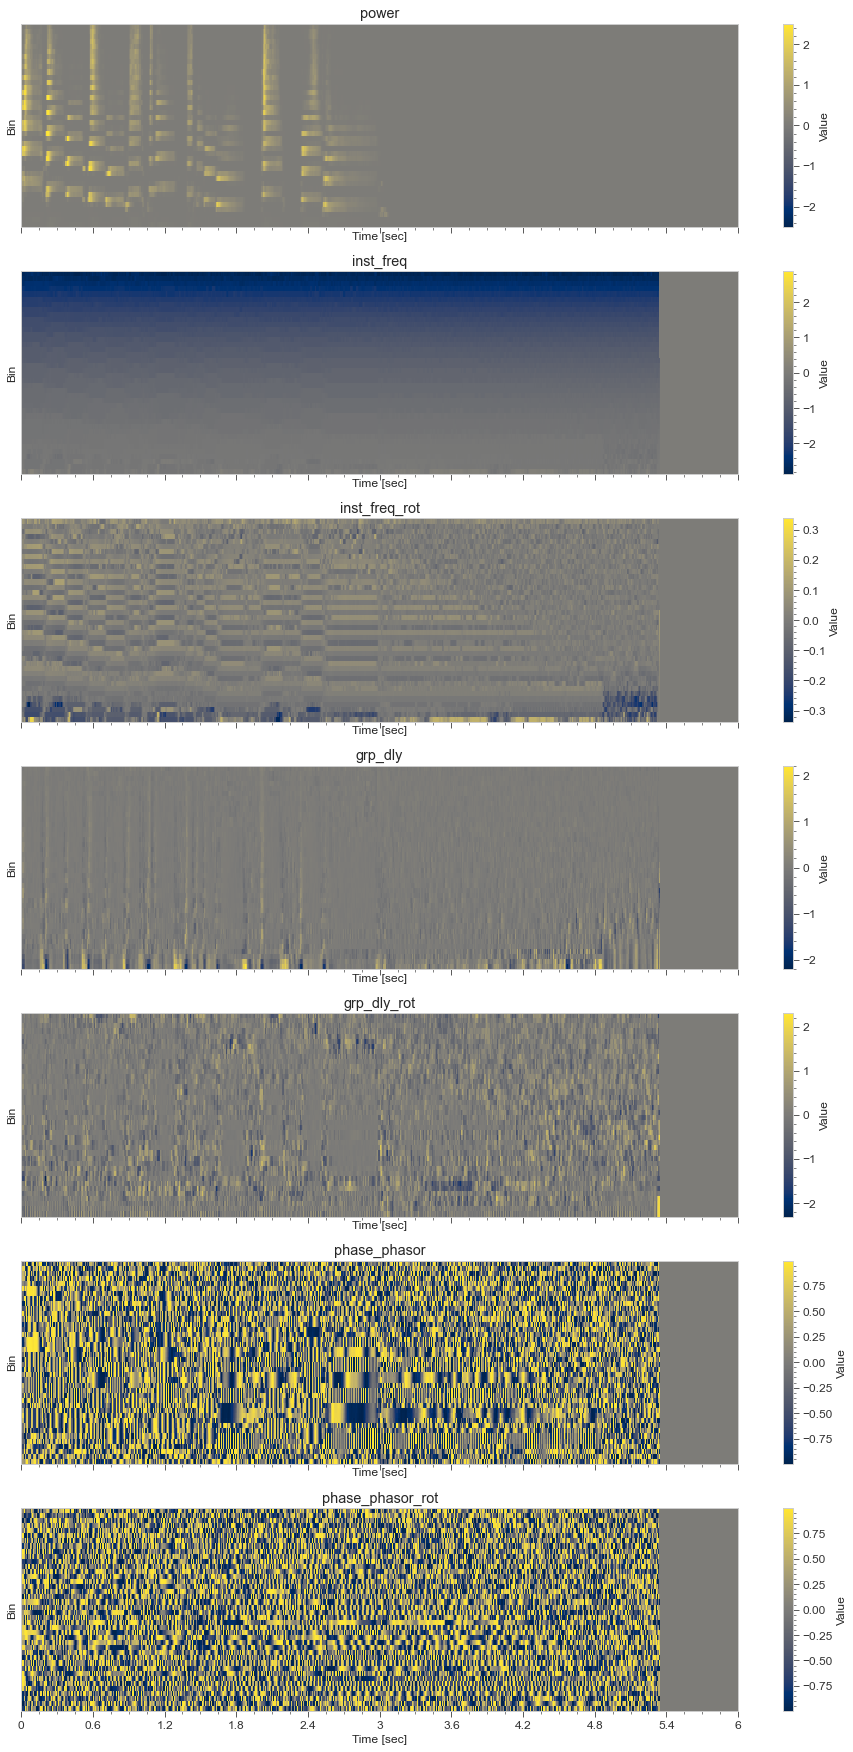

In [6]:
################################################################################
### Configuration
################################################################################
downsampler_init = 0.4
phase_feat_attn_power = False

filter_size = 401
filter_stride = 160  # 160
n_bins = 40
sample_rate = 16000

compressor_alpha = 0.96
compressor_delta = 2.0
compressor_root = 2.0
compressor_smooth_coef = 0.04


################################################################################
### Processing
################################################################################
features = sorted(AVAILABLE_FEATURES_INFO._fields, key=lambda x: getattr(AVAILABLE_FEATURES_INFO, x).cmplx)


wave, sr = librosa.load(librosa.ex('trumpet'), sr=sample_rate)
wave = np.pad(wave, (0, sr - wave.shape[0]%sr))
wave = torch.from_numpy(wave.reshape(1, 1, -1))  # shape=(batch=1, channels=1, time)

channels = np.arange(len(features))

net = LEAF(
    n_bins=n_bins,
    features=features,
    downsampler_init=downsampler_init,
    phase_feat_attn_power=phase_feat_attn_power,
#     spec_augment=True
)
net.eval()
outputs_torch = net(wave)
outputs = outputs_torch.detach().numpy()[0]


fig, axes = plt.subplots(len(features), 1, figsize=(13, len(features)*3.5),
                         sharex=True)


kwargs_base = dict(hop_length=filter_stride, sr=sample_rate, x_axis='s')

for c, f, ax in zip(channels, features, axes):
    o = outputs[c]
    kwargs = kwargs_base.copy()
    vmax = np.max(np.abs(o))
    vmin = -vmax
    kwargs.update(dict(cmap='cividis', vmin=vmin, vmax=vmax))
    sm = librosa.display.specshow(o, ax=ax, **kwargs)
    ax.set(title=f, xlabel='Time [sec]', ylabel='Bin')
    cbar = fig.colorbar(sm, ax=ax, label='Value')

fig.tight_layout()

***
*End*